## Importing needed packages

In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
from scipy.stats import norm

## Loading Data from Excel

In [2]:
CapCost = pd.read_excel('Data/CAPEX.xlsx')
OpCost = pd.read_excel('Data/OPEX.xlsx')
TechInfo = pd.read_excel('Data/TechInfo.xlsx')
StorCost = pd.read_excel('Data/StorageCapex.xlsx')
CapLim = pd.read_excel('Data/CapacityLimit.xlsx')
CapExi = pd.read_excel('Data/ExistingCapacity.xlsx')
CapOut = pd.read_excel('Data/CapacityOut.xlsx')
Demand = pd.read_excel('Data/Demand.xlsx')
StorExi = pd.read_excel('Data/ExistingStorage.xlsx')
CapacityFactors= pd.read_excel('Data/CapacityFactors.xlsx')
StorLim = pd.read_excel('Data/StorageLimit.xlsx')

## Transform data frames into matrix

In [3]:
CapCost = np.array(CapCost['Annualized Investment Cost [EUR/kW]'])
OpCost = np.array(OpCost['Total OPEX'])
#TechInfo = np.array(TechInfo['Type'])
StorCost = np.array(StorCost['CAPEX [EUR/kW]'])
CapLim = np.array(CapLim['Maximum Capacity [GW]'])
CapExi = np.array(CapExi['Capacity [GW]'])
CapOut = np.array(CapOut['Maximum Capacity [GW]'])
Demand = np.array(Demand['Demand [GWh]'])
StorExi = np.array(StorExi['Capacity [GWh]'])
ProdFacOffWind = np.array(CapacityFactors['Offshore Capacity Factor'])
ProdFacOnWind = np.array(CapacityFactors['Onshore Capacity Factor'])
ProdFacSolar = np.array(CapacityFactors['Solar Capacity Factor'])
StorLim = np.array(StorLim['Maximum Capacity [GWh]'])


## Defining Input Data

In [4]:
# # Create a dataframe for Capacity Cost
# CapCost = pd.DataFrame({
#     'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
#     'CapCost[€/MW]': [150, 100, 2500, 9000, 9000]
# })

# # Create a dataframe for Operating Cost
# OpCost = pd.DataFrame({
#     'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
#     'OpCost[€/MWh]': [200, 250, 500, 0, 0]
# })

# # Create a dataframe to define general technology information
# TechInfo = pd.DataFrame({
#     'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
#     'Type': ['Fossil', 'Fossil', 'Fossil', 'RES', 'RES']
# })

# # Create a dataframe for Storage Cost
# StorCost = pd.DataFrame({
#     'Plant': ['Battery', 'Pumped Hydro'],
#     'StorCost[€/MWh]': [10, 50000000]
# })

# # Create a dataframe for Capacity Limit
# CapLim = pd.DataFrame({
#     'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
#     'CapLim[MW]': [100000, 100000, 100000, 10000000, 10000000]
# })

# # Create a dataframe for existing capacity
# CapExi = pd.DataFrame({
#     'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
#     'ExCap[MW]': [100, 50, 50, 100, 100]
# })

# # Create a dataframe for outphased capacity
# CapOut = pd.DataFrame({
#     'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
#     'OutCap[MW]': [0, 0, 0, -50, 0]
# })


# # Create a dataframe for demand on hourly basis
# Demand = pd.DataFrame({
#     'Hour': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
#     'Demand[MWh]': [500,60,555,343,644,343,535,223,535,634,90,535,223,535,634,343,535,223,535,634,943,535,223,535]
# })

# Create a dataframe for eta charge
EtaCh = pd.DataFrame({
    'Plant': ['Battery', 'Pumped Hydro'],
    'EtaCh': [0.9, 0.8]
})

# Create a dataframe for eta discharge
EtaDis = pd.DataFrame({
    'Plant': ['Battery', 'Pumped Hydro'],
    'EtaDis': [0.9, 0.8]
})

# # Create a dataframe for existing storage capacity
# StorExi = pd.DataFrame({
#     'Plant': ['Battery', 'Pumped Hydro'],
#     'ExStor[MWh]': [40, 0]
# })


In [5]:
num_hours_per_year = len(Demand)
num_years = 4
num_scenarios = 10  # Number of new scenarios to generate

# Reshape your data (shape: (8760, 4))
ProdFacOffWind = ProdFacOffWind.reshape((num_years, num_hours_per_year)).T
ProdFacOnWind = ProdFacOnWind.reshape((num_years, num_hours_per_year)).T
ProdFacSolar = ProdFacSolar.reshape((num_years, num_hours_per_year)).T

# Now shape = (8760, 4)
# Each row corresponds to one specific hour-of-year across all 4 years

# Step 1: Calculate Mean & Std per Hour
OffWindMean = np.mean(ProdFacOffWind, axis=1)
OffWindStd = np.maximum(0.3 * OffWindMean, 0.1)

OnWindMean = np.mean(ProdFacOnWind, axis=1)
OnWindStd = np.maximum(0.3 * OnWindMean, 0.1)

SolarMean = np.mean(ProdFacSolar, axis=1)
SolarStd = np.maximum(0.05 * SolarMean, 0.01)

# Step 2: Generate Scenarios
Offwind_scenarios = np.clip(
    np.random.normal(OffWindMean[:, None], OffWindStd[:, None], (num_hours_per_year, num_scenarios)),
    0, 1
)

Onwind_scenarios = np.clip(
    np.random.normal(OnWindMean[:, None], OnWindStd[:, None], (num_hours_per_year, num_scenarios)),
    0, 1
)

Solar_scenarios = np.clip(
    np.random.normal(SolarMean[:, None], SolarStd[:, None], (num_hours_per_year, num_scenarios)),
    0, 1
)


## Data Sampling

In [6]:


# # # Transpose to correct format (Hours × 1 Scenario)
# # ProdFacOffWind = ProdFacOffWind.T  # Shape: (24, 1)
# # ProdFacSolar = ProdFacSolar.T  # Shape: (24, 1)

# # Number of new scenarios to generate
# num_scenarios = 1
# num_hours = len(Demand)  

# # Step 1: Fit Normal Distributions for Each Hour (Using Small Variability)
# OffWindDistributions = {}
# OnWindDistributions = {}
# solar_distributions = {}

# for hour in range(num_hours):
#     # Offshore Wind
#     OffWindMean = ProdFacOffWind[hour]
#     Offwind_std_dev = max(0.15 * OffWindMean, 0.05)  # 5% of mean, at least 0.01
#     OffWindDistributions[hour] = (OffWindMean, Offwind_std_dev)

#     # Onshore Wind
#     OnWindMean = ProdFacOnWind[hour]
#     Onwind_std_dev = max(0.15 * OnWindMean, 0.05)  # 5% of mean, at least 0.01
#     OnWindDistributions[hour] = (OnWindMean, Onwind_std_dev)

#     # Solar
#     solar_mean = ProdFacSolar[hour]
#     solar_std_dev = max(0.05 * solar_mean, 0.01)  # 5% of mean, at least 0.01
#     solar_distributions[hour] = (solar_mean, solar_std_dev)

# # Step 2: Generate New Scenarios Using Monte Carlo Sampling
# Offwind_scenarios = np.zeros((num_hours, num_scenarios))
# Onwind_scenarios = np.zeros((num_hours, num_scenarios))
# Solar_scenarios = np.zeros((num_hours, num_scenarios))

# for scenario in range(num_scenarios):
#     for hour in range(num_hours):
#         # Offshore Wind Sampling
#         OffWindMean, Offwind_std_dev = OffWindDistributions[hour]
#         Offwind_sample = np.random.normal(OffWindMean, Offwind_std_dev)
#         Offwind_scenarios[hour, scenario] = np.clip(Offwind_sample, 0, 1)

#         # Onshore Wind Sampling
#         OnWindMean, Onwind_std_dev = OnWindDistributions[hour]
#         Onwind_sample = np.random.normal(OnWindMean, Onwind_std_dev)
#         Onwind_scenarios[hour, scenario] = np.clip(Onwind_sample, 0, 1)

#         # Solar Sampling
#         solar_mean, solar_std_dev = solar_distributions[hour]
#         solar_sample = np.random.normal(solar_mean, solar_std_dev)
#         Solar_scenarios[hour, scenario] = np.clip(solar_sample, 0, 1)

In [7]:
#Create a plot for the wind power scenarios



## Defining Input Parameters

In [8]:
# Define number of hours as length of demand
N_Hours = len(Demand)

# Define number of generators as length of CapCost
N_Cap = len(CapCost)

# Define number of storage as length of StorCost
N_Stor = len(StorCost)

# Define number of scenarios as number of columns in ProdFacWind
N_Scen = num_scenarios

# Define epsilon
epsilon = 0.1

#Define delta
delta = 0.7

BigM = 1000000

DemandScaleFactor = 750/464

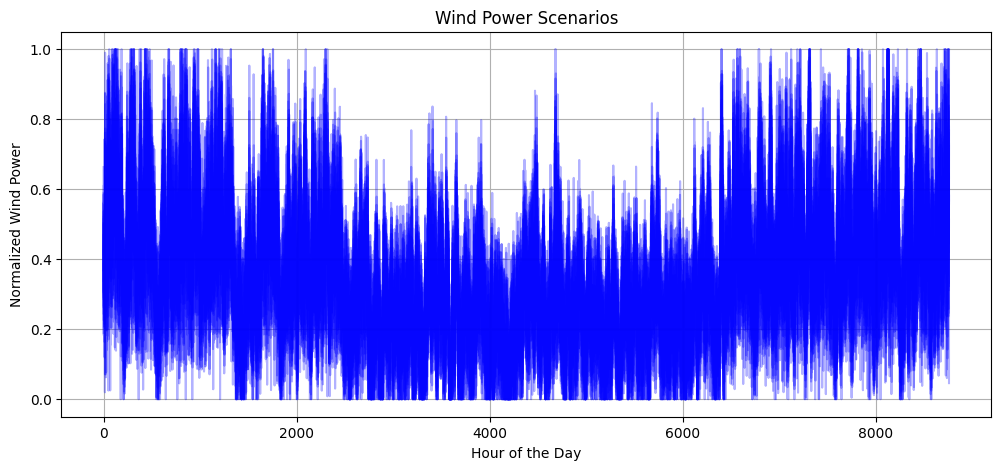

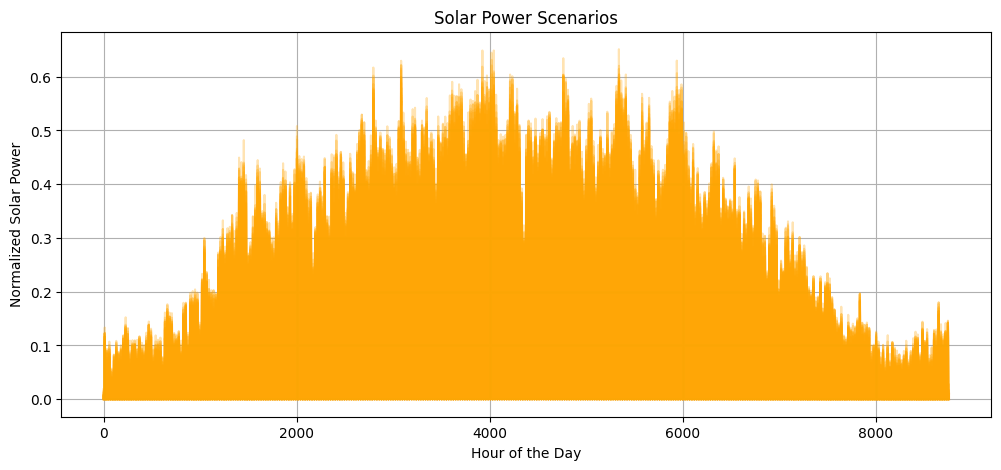

In [9]:
import matplotlib.pyplot as plt

# Plot Wind Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  # Plot only first 50 scenarios for clarity
    plt.plot(range(N_Hours), Offwind_scenarios[:, scenario], alpha=0.3, color='blue')
plt.title("Wind Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Wind Power")
plt.grid(True)
plt.show()

# Plot Solar Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  # Plot only first 50 scenarios for clarity
    plt.plot(range(N_Hours), Solar_scenarios[:, scenario], alpha=0.3, color='orange')
plt.title("Solar Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Solar Power")
plt.grid(True)
plt.show()

## Defining classes

In [10]:
# Class for external input data
class InputData():
    def __init__(self, CapCost, OpCost, TechInfo, StorCost, CapLim,CapExi,CapOut,Dem,EtaCha,EtaDis,StorExi, Offwind_scenarios, Onwind_scenarios, Solar_scenarios, StorLim):
        self.CapCost = CapCost
        self.OpCost = OpCost
        self.TechInfo = TechInfo
        self.StorCost = StorCost
        self.CapLim = CapLim
        self.CapExi = CapExi
        self.CapOut = CapOut
        self.Dem = Dem
        self.EtaCha = EtaCha
        self.EtaDis = EtaDis
        self.StorExi = StorExi
        self.Offwind_scenarios = Offwind_scenarios
        self.Onwind_scenarios = Onwind_scenarios
        self.Solar_scenarios = Solar_scenarios
        self.StorLim = StorLim
        

        

In [11]:
# Class for model parameters
class Parameters():
    def __init__(self, epsilon, delta, N_Hours, N_Cap, N_Stor, N_Scen, BigM,DemandScaleFactor):
        self.epsilon = epsilon
        self.delta = delta
        self.N_Hours = N_Hours
        self.N_Cap = N_Cap
        self.N_Stor = N_Stor
        self.N_Scen = N_Scen
        self.BigM = BigM
        self.DemandScaleFactor = DemandScaleFactor

        # Create Vectors for vector multiplication
        self.hourvector = np.ones((N_Hours,1))
        self.genvector = np.ones((N_Cap,1))
        self.storvector = np.ones((N_Stor,1))
        self.scenvector = np.ones((N_Scen,1))

## Creating Data and Parameter Objects

In [12]:
ParametersObj = Parameters(epsilon, delta, N_Hours, N_Cap, N_Stor, N_Scen, BigM, DemandScaleFactor)
DataObj = InputData(CapCost, OpCost, TechInfo, StorCost, CapLim,CapExi,CapOut,Demand,EtaCh,EtaDis,StorExi, Offwind_scenarios, Onwind_scenarios, Solar_scenarios, StorLim)


## Creating the Model

In [13]:
# CLASS WHICH CAN HAVE ATTRIBUTES SET

class Expando(object):
    '''
        A small class which can have attributes set
    '''
    pass

In [14]:
# Defining the optimization model class

class CapacityProblem():
    def __init__(self, ParametersObj, DataObj, Model_results = 1, Guroby_results = 1):
        self.P = ParametersObj # Parameters
        self.D = DataObj # Data
        self.Model_results = Model_results
        self.Guroby_results = Guroby_results
        self.var = Expando()  # Variables
        self.con = Expando()  # Constraints
        self.res = Expando()  # Results
        self._build_model() 


    def _build_variables(self):
        # Create the variables
        self.var.CapNew = self.m.addMVar((self.P.N_Cap), lb=0)  # New Capacity for each type of generator technology
        self.var.EGen = self.m.addMVar((self.P.N_Cap, self.P.N_Hours, self.P.N_Scen), lb=0)  # Energy Production for each type of generator technology for each hour and scenario
        self.var.CapStor = self.m.addMVar((self.P.N_Stor), lb=0)  # New storage capacity for each type of storage technology
        self.var.SOC = self.m.addMVar((self.P.N_Stor, self.P.N_Hours,self.P.N_Scen), lb=0)  # State of charge for each type of storage technology for each hour and scenario  
        self.var.EChar = self.m.addMVar((self.P.N_Stor, self.P.N_Hours,self.P.N_Scen), lb=0)  # Energy charged for each type of storage technology for each hour and scenario
        self.var.EDis = self.m.addMVar((self.P.N_Stor, self.P.N_Hours,self.P.N_Scen), lb=0)  # Energy discharged for each type of storage technology for each hour and scenario
        self.var.u = self.m.addMVar((self.P.N_Scen), vtype=GRB.BINARY) # Binary variable for each scenario  # Chance for each scenario


    def _build_constraints(self):
    
        G, H, S = self.P.N_Cap, self.P.N_Hours, self.P.N_Scen
        U = self.P.N_Stor

        # --- Capacity Limits ---
        self.con.CapLim = self.m.addConstr(self.var.CapNew <= self.D.CapLim, name='Capacitylimit')
        self.con.CapStorLim = self.m.addConstr(self.var.CapStor <= self.D.StorLim, name='Storage capacity limit')

        # --- Production Limits ---
        CapTotal = self.var.CapNew.reshape((G, 1, 1)) + self.D.CapExi.reshape((G, 1, 1)) + self.D.CapOut.reshape((G, 1, 1))

        Techs = self.D.TechInfo['Technology'].values
        OffshoreMask = (Techs == 'Wind Offshore')
        OnshoreMask = (Techs == 'Wind Onshore')
        SolarMask = (Techs == 'PV')
        ConvMask = ~(OffshoreMask | OnshoreMask | SolarMask)

        if OffshoreMask.any():
            self.con.ProdLim_Offshore = self.m.addConstr(
                self.var.EGen[OffshoreMask, :, :] <= CapTotal[OffshoreMask, :, :] * self.D.Offwind_scenarios[None, :, :],
                name='ProdLimit_Offshore'
            )
        if OnshoreMask.any():
            self.con.ProdLim_Onshore = self.m.addConstr(
                self.var.EGen[OnshoreMask, :, :] <= CapTotal[OnshoreMask, :, :] * self.D.Onwind_scenarios[None, :, :],
                name='ProdLimit_Onshore'
            )
        if SolarMask.any():
            self.con.ProdLim_Solar = self.m.addConstr(
                self.var.EGen[SolarMask, :, :] <= CapTotal[SolarMask, :, :] * self.D.Solar_scenarios[None, :, :],
                name='ProdLimit_Solar'
            )
        if ConvMask.any():
            self.con.ProdLim_Conv = self.m.addConstr(
                self.var.EGen[ConvMask, :, :] <= CapTotal[ConvMask, :, :],
                name='ProdLimit_Conventional'
            )

        # --- Energy Balance (vectorized over H x S) ---
        EGen_sum = self.var.EGen.sum(axis=0)    # shape (H, S)
        EDis_sum = self.var.EDis.sum(axis=0)    # shape (H, S)
        EChar_sum = self.var.EChar.sum(axis=0)  # shape (H, S)
        Demand_scaled = self.D.Dem[:, None] * self.P.DemandScaleFactor  # shape (H, 1), broadcast to (H, S)

        self.con.Balance = self.m.addConstr(EGen_sum + EDis_sum == Demand_scaled + EChar_sum, name='EnergyBalance')

        # --- RES Share (partial vectorization; filtering RES still needs logic) ---
        RES_mask = (self.D.TechInfo['Type'] == 'RES').values
        if RES_mask.any():
            TotalDemand = np.sum(self.D.Dem)  # scalar
            RES_gen = self.var.EGen[RES_mask, :, :].sum(axis=(0, 1))  # shape (S,)
            self.con.RESShare = self.m.addConstr(
                self.P.delta * TotalDemand - RES_gen <= self.P.BigM * (1 - self.var.u),
                name='RESShare'
            )

        # --- Scenario Violation (vectorized) ---
        self.con.ScenViol = self.m.addConstr(gp.quicksum(self.var.u[s] for s in range(self.P.N_Scen))/self.P.N_Scen >= (1- self.P.epsilon), name=f'Scenario violation')

        # --- SOC Dynamics (hourly update, vectorized over U x H x S) ---
        SOC = self.var.SOC
        EChar = self.var.EChar
        EDis = self.var.EDis

        # State of charge for hours > 0
        SOC_prev = SOC[:, :-1, :]  # (U, H-1, S)
        EChar_prev = EChar[:, :-1, :]
        EDis_prev = EDis[:, :-1, :]
        SOC_curr = SOC[:, 1:, :]

        self.con.SOC_Update = self.m.addConstr(SOC_curr == SOC_prev + EChar_prev - EDis_prev, name='SOC_Update')

        # Initial SOC
        self.con.SOC0 = self.m.addConstr(SOC[:, 0, :] == self.D.StorExi[:, None], name='SOC_Initial')

        # --- Storage Capacity Limit ---
        self.con.SOCLim = self.m.addConstr(
            SOC <= self.var.CapStor[:, None, None] + self.D.StorExi[:, None, None],
            name='StorageCapLimit'
        )

        # --- Charge and Discharge Limits ---
        self.con.ECharLim = self.m.addConstr(
            EChar <= self.var.CapStor[:, None, None] + self.D.StorExi[:, None, None] - SOC,
            name='ECharLimit'
        )
        self.con.EDisLim = self.m.addConstr(
            EDis <= SOC,
            name='EDisLimit'
        )

        
    
    def _build_objective(self):
        # Vectorized investment cost for generators
        capex_cost = self.var.CapNew @ self.D.CapCost  # dot product: (G,) @ (G,) → scalar

        # Vectorized operational cost for generation
        # Need to multiply OpCost (G,) across all (H, S) → reshape to (G, 1, 1) for broadcasting
        op_cost = (self.var.EGen * self.D.OpCost[:, None, None]).sum()

        # Vectorized storage investment cost
        stor_cost = self.var.CapStor @ self.D.StorCost  # dot product: (U,) @ (U,) → scalar

        # Set objective
        self.m.setObjective(capex_cost + op_cost + stor_cost, GRB.MINIMIZE)


    def _display_guropby_results(self):
        self.m.setParam('OutputFlag', self.Guroby_results)

    
    def _build_model(self):
        self.m = gp.Model('CapacityProblem')
        self._build_variables()
        self._build_constraints()
        self._build_objective()
        self._display_guropby_results()
        self.m.write("CapacityProblem.lp")
        self.m.optimize()
        self._results()
        if self.Model_results == 1:
            self._extract_results()
            

    
    def _results(self):
        self.res.obj = self.m.objVal
        self.res.CapNew = self.var.CapNew.X
        self.res.EGen = self.var.EGen.X
        self.res.CapStor = self.var.CapStor.X
        self.res.SOC = self.var.SOC.X
        self.res.EChar = self.var.EChar.X
        self.res.EDis = self.var.EDis.X
        self.res.u = self.var.u.X
         
        
        #Create Dataframe for new capacity
        self.res.CapNew = pd.DataFrame({
            'Plant': ['Offshore', 'Onshore', 'Biomass', 'Lignite', 'Hard Coal', 'Gas', 'Hydrogren', 'Nuclear', 'Solar PV', 'Hydro', 'Other RES', 'Other Conventional'],
            'CapNew[MW]': self.res.CapNew,
            'CapExi[MW]': self.D.CapExi,
            'CapOut[MW]': self.D.CapOut
        })

        #Create Dataframe for new storage capacity
        self.res.CapStor = pd.DataFrame({
            'Plant': ['Battery', 'Pumped Hydro'],
            'CapStor[MWh]': self.res.CapStor
        })

        # Create DataFrame for scenario violations
        self.res.Violation_Scenarios = pd.DataFrame({
            'Scenario': list(range(self.P.N_Scen)),
            'Violated (1=No, 0=Yes)': self.res.u
        })
        
        
    

        self.res.EGen_Scenarios = {}

        for s in range(self.P.N_Scen):
            # Extract data for scenario `s`
            e_gen_scenario = self.res.EGen[:, :, s].T  # Transpose to match (Hours x Generators)
            soc_scenario = self.res.SOC[:, :, s].T  # (Hours x Storage Technologies)
            echar_scenario = self.res.EChar[:, :, s].T  # (Hours x Storage Technologies)
            edis_scenario = self.res.EDis[:, :, s].T  # (Hours x Storage Technologies)

            # Extract Wind and Solar Production Factors
            Offwind_scenarios = self.D.Offwind_scenarios[:, s]  # Extract Wind Production Factor for scenario `s`
            Onwind_scenarios = self.D.Onwind_scenarios[:, s]  # Extract Wind Production Factor for scenario `s`
            Solar_scenarios = self.D.Solar_scenarios[:, s]  # Extract Solar Production Factor for scenario `s`

            # Convert to DataFrames
            df_scenario = pd.DataFrame(e_gen_scenario, columns=['Offshore', 'Onshore', 'Biomass', 'Lignite', 'Hard Coal', 'Gas', 'Hydrogren', 'Nuclear', 'Solar PV', 'Hydro', 'Other RES', 'Other Conventional'])
            df_soc = pd.DataFrame(soc_scenario, columns=['Battery_SOC', 'PumpedHydro_SOC'])
            df_echar = pd.DataFrame(echar_scenario, columns=['Battery_Charge', 'PumpedHydro_Charge'])
            df_edis = pd.DataFrame(edis_scenario, columns=['Battery_Discharge', 'PumpedHydro_Discharge'])
            df_demand = pd.DataFrame({'Demand': self.D.Dem})

            # Add Wind & Solar Production Factors
            df_prod_factors = pd.DataFrame({'OffWind': Offwind_scenarios, 'OnWind': Onwind_scenarios, 'Solar': Solar_scenarios})

            # Add Hour column
            df_scenario['Hour'] = list(range(self.P.N_Hours))

            # Merge all DataFrames
            df_complete = pd.concat([df_scenario, df_soc, df_echar, df_edis, df_demand, df_prod_factors], axis=1)

            # Reorder columns
            df_complete = df_complete[['Hour', 'Offshore', 'Onshore', 'Biomass', 'Lignite', 'Hard Coal', 'Gas', 'Hydrogren', 'Nuclear', 'Solar PV', 'Hydro', 'Other RES', 'Other Conventional',
                                    'Battery_SOC', 'PumpedHydro_SOC',
                                    'Battery_Charge', 'PumpedHydro_Charge',
                                    'Battery_Discharge', 'PumpedHydro_Discharge',
                                    'Demand', 'OffWind','OnWind', 'Solar']]

            # Store in dictionary
            self.res.EGen_Scenarios[f"Scenario_{s}"] = df_complete
    

    def _extract_results(self):
        # Display the objective value
        print('Objective value: ', self.m.objVal)
        # Display the new capacity for each type of generator technology
        print('New capacity for each type of generator technology: ', self.res.CapNew)
        
        #Display new storage capacity for each type of storage technology
        print('New storage capacity for each type of storage technology: ', self.res.CapStor)

        

## Execute the model

In [15]:
CapacityProblem = CapacityProblem(ParametersObj, DataObj)
#CapacityProblem._results()
#CapacityProblem._extract_results()

ResultsCapacity = CapacityProblem.res.CapNew
ResultsStorage = CapacityProblem.res.CapStor
#ResultsViolations = CapacityProblem.res.Violation_Scenarios

for scenario_name, df in CapacityProblem.res.EGen_Scenarios.items():
    df.to_csv(f"{scenario_name}.csv", index=False)  # Save each scenario as a CSV file
    print(f"Saved {scenario_name}.csv")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-14


KeyboardInterrupt: 